# 물체 탐지(Object detection) - SSD


https://github.com/pierluigiferrari/ssd_keras의 ssd300_inference.ipynb를 기반으로 한다.



## 프로젝트 다운로드


In [6]:
%cd /content

!rm -rf ssd_keras

!git clone https://github.com/pierluigiferrari/ssd_keras


/content
Cloning into 'ssd_keras'...
remote: Enumerating objects: 1608, done.
remote: Total 1608 (delta 0), reused 0 (delta 0), pack-reused 1608
Receiving objects: 100% (1608/1608), 19.71 MiB | 7.80 MiB/s, done.
Resolving deltas: 100% (1056/1056), done.


## 학습된 모델 파일 다운로드


이미 학습된 SSD 모델 파일 VGG_coco_SSD_300x300_iter_400000.h5은

다음 페이지의 'COCO[1]: SSD300*'에 걸린 링크로 다운 받는다.

https://github.com/pierluigiferrari/ssd_keras#download-the-original-trained-model-weights

files.upload()로 업로드하면 1시간 이상 시간이 걸린다.


대신 dropbox에 임시로 올려둔 파일에서 다운로드 한다. wget으로 다운로드 받는다.

In [7]:
%cd ssd_keras

!wget -O VGG_coco_SSD_300x300.h5 https://www.dropbox.com/s/z7sf5c8wx39fo9n/VGG_coco_SSD_300x300.h5?dl=1
  
!ls -al

/content/ssd_keras
--2019-08-06 09:29:56--  https://www.dropbox.com/s/z7sf5c8wx39fo9n/VGG_coco_SSD_300x300.h5?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/z7sf5c8wx39fo9n/VGG_coco_SSD_300x300.h5 [following]
--2019-08-06 09:29:57--  https://www.dropbox.com/s/dl/z7sf5c8wx39fo9n/VGG_coco_SSD_300x300.h5
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1f4ccc6e1c5c0fad95eab07953.dl.dropboxusercontent.com/cd/0/get/AmE7AUqGoVyMVb1WLA9v_jmVHNpQC4UqaKqwgi94XC-Jku35eq0eXw7_RlHFqQB9-v1TLLz1_8jBlcN6wTi9u1CFoMbEvjzBmAAC95ngHgfULQ/file?dl=1# [following]
--2019-08-06 09:29:57--  https://uc1f4ccc6e1c5c0fad95eab07953.dl.dropboxusercontent.com/cd/0/get/AmE7AUqGoVyMVb1WLA9v_jmVHNpQC4UqaKqwgi94XC-Jku35eq0eXw7_RlHFqQB9-v1TLLz1_8jBlc

## 모델 정의와 로딩

In [9]:
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
from keras.optimizers import Adam
from imageio import imread
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

%matplotlib inline


img_height = 300
img_width = 300

K.clear_session()

model = ssd_300(image_size=(img_height, img_width, 3),
                n_classes=20,
                mode='inference',
                l2_regularization=0.0005,
                scales=[0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05], # The scales for MS COCO are [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05]
                aspect_ratios_per_layer=[[1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5]],
                two_boxes_for_ar1=True,
                steps=[8, 16, 32, 64, 100, 300],
                offsets=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
                clip_boxes=False,
                variances=[0.1, 0.1, 0.2, 0.2],
                normalize_coords=True,
                subtract_mean=[123, 117, 104],
                swap_channels=[2, 1, 0],
                confidence_thresh=0.5,
                iou_threshold=0.45,
                top_k=200,
                nms_max_output_size=400)

#weights_path = 'path/to/trained/weights/VGG_VOC0712_SSD_300x300_iter_120000.h5'
weights_path = 'VGG_coco_SSD_300x300.h5'


model.load_weights(weights_path, by_name=True)
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

W0806 09:31:12.567137 140709630314368 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0806 09:31:12.569523 140709630314368 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0806 09:31:12.638074 140709630314368 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0806 09:31:12.639849 140709630314368 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W080

## 실행

In [0]:
# ssd300_inference.ipynb의 코드를 함수화 함

def do_detect(img_path):

  orig_images = []
  input_images = []

  orig_images.append(imread(img_path))
  img = image.load_img(img_path, target_size=(img_height, img_width))
  img = image.img_to_array(img) 
  input_images.append(img)
  input_images = np.array(input_images)


  y_pred = model.predict(input_images)


  confidence_threshold = 0.5

  y_pred_thresh = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]

  np.set_printoptions(precision=2, suppress=True, linewidth=90)
  print("Predicted boxes:\n")
  print('   class   conf xmin   ymin   xmax   ymax')
  print(y_pred_thresh[0])  

  colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
  classes = ['background',
            'aeroplane', 'bicycle', 'bird', 'boat',
            'bottle', 'bus', 'car', 'cat',
            'chair', 'cow', 'diningtable', 'dog',
            'horse', 'motorbike', 'person', 'pottedplant',
            'sheep', 'sofa', 'train', 'tvmonitor']

  plt.figure(figsize=(20,12))
  plt.imshow(orig_images[0])

  current_axis = plt.gca()

  for box in y_pred_thresh[0]:
      xmin = box[2] * orig_images[0].shape[1] / img_width
      ymin = box[3] * orig_images[0].shape[0] / img_height
      xmax = box[4] * orig_images[0].shape[1] / img_width
      ymax = box[5] * orig_images[0].shape[0] / img_height
      color = colors[int(box[0])]
      label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
      current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
      current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})  

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[ 15.     0.98 117.57  -3.39 215.29 164.84]]


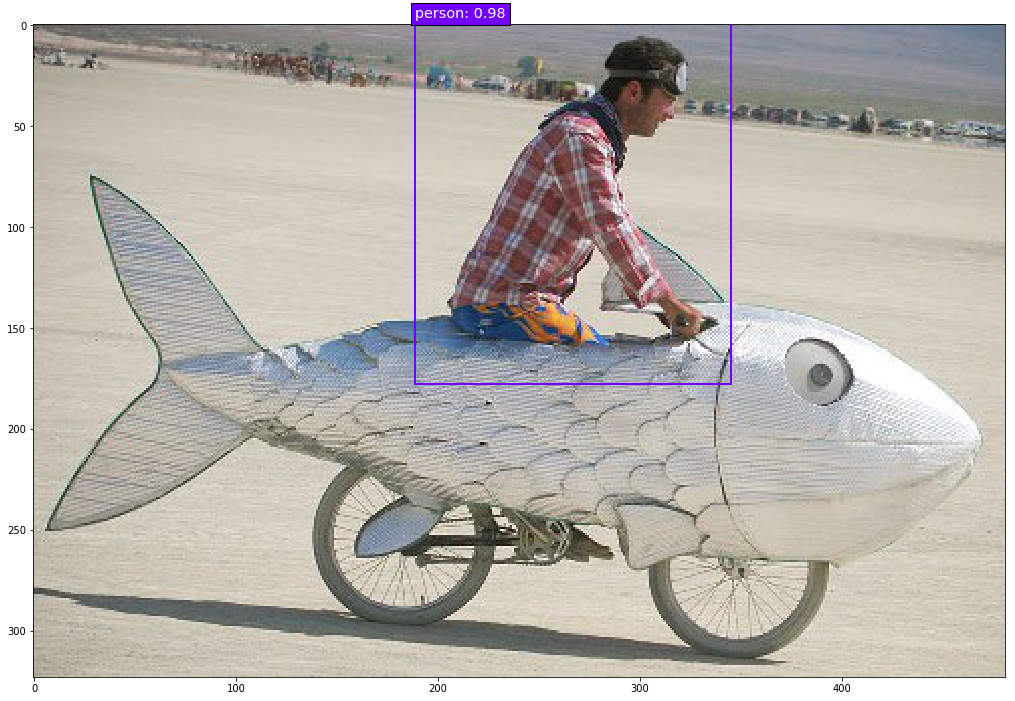

In [19]:
do_detect('examples/fish_bike.jpg')

## 다른 이미지에 물체 탐지

--2019-08-06 09:37:17--  http://beltlineorg-wpengine.netdna-ssl.com/wp-content/uploads/2012/12/IMG_5669-flickr-websized.jpg
Resolving beltlineorg-wpengine.netdna-ssl.com (beltlineorg-wpengine.netdna-ssl.com)... 94.31.29.96
Connecting to beltlineorg-wpengine.netdna-ssl.com (beltlineorg-wpengine.netdna-ssl.com)|94.31.29.96|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 89406 (87K) [image/jpeg]
Saving to: ‘street_view.jpg’

street_view.jpg     100%[===================>]  87.31K   339KB/s    in 0.3s    

2019-08-06 09:37:17 (339 KB/s) - ‘street_view.jpg’ saved [89406/89406]



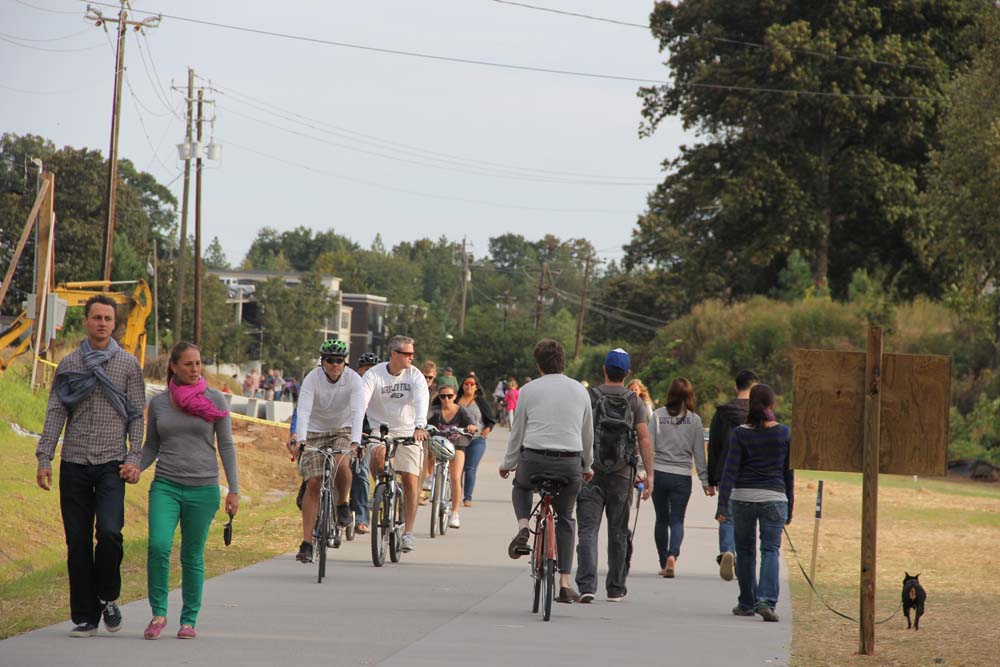

In [16]:
!wget -O street_view.jpg http://beltlineorg-wpengine.netdna-ssl.com/wp-content/uploads/2012/12/IMG_5669-flickr-websized.jpg

from IPython.display import Image, display
display(Image(filename='street_view.jpg')) 

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[ 15.     0.94 192.38 150.39 217.26 279.49]
 [ 15.     0.89 106.51 132.18 135.07 256.61]
 [ 15.     0.84 170.96 139.76 197.47 284.48]
 [ 15.     0.72 146.47 137.68 180.53 294.19]
 [ 15.     0.68   8.19 119.15  46.67 299.24]
 [ 15.     0.66 207.94 154.97 240.05 302.18]
 [ 15.     0.59  80.95 133.52 112.62 261.9 ]
 [ 15.     0.56 267.4  251.01 278.83 289.5 ]]


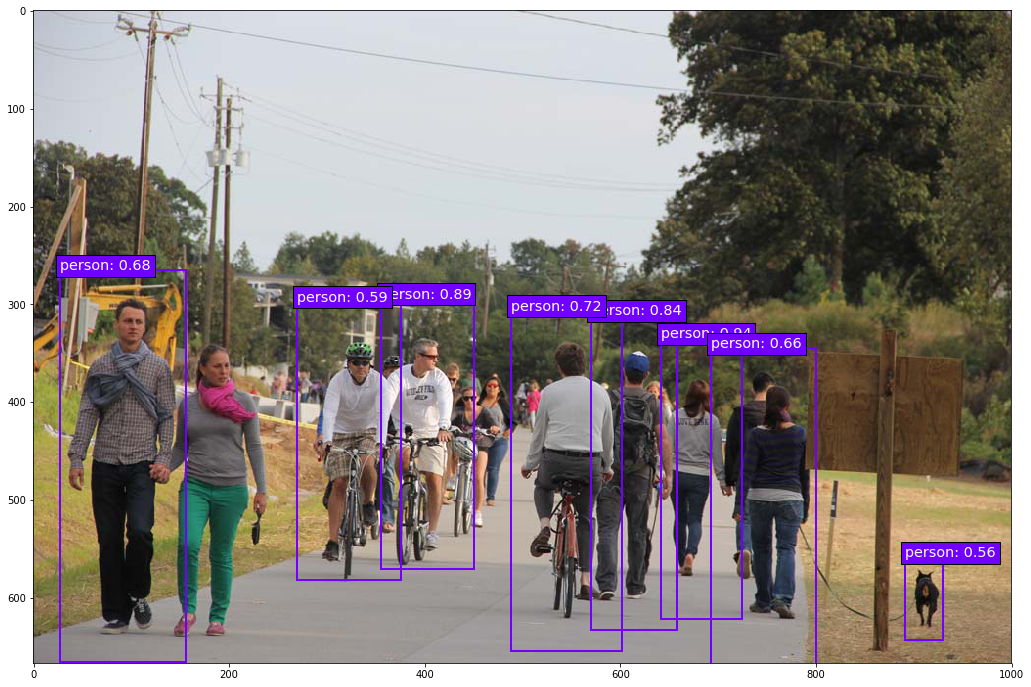

In [21]:
do_detect('street_view.jpg')